# Volume 4: Poisson's Equation
    Daniel Perkins
    MATH 439
    12/8/24

In [3]:
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as spla
from matplotlib import pyplot as plt, colors as mcolors
from imageio.v3 import imread

# %matplotlib notebook
%matplotlib inline

# Problem 1

Complete the function `poisson_square` by implementing the finite difference method given in the lab. Use `scipy.sparse.linalg.spsolve` to solve the linear system. Use your function to solve the boundary value problem:

\begin{align}
	\Delta u = 0, &{}\quad x \in [0,1]\times [0,1],\\
	u(x,y) = x^3, &{}\quad (x,y) \in \partial ([0,1]\times [0,1])
\end{align}

Use $n=100$ subintervals for both $x$ and $y$. Plot the solution as a 3D surface.

In [4]:
def poisson_square(a, b, c, d, f, g, n):
    """Computes the finite difference method for the Poisson equation boundary-value
    problem on a square:
        
        u_xx + u_yy = f on R = [a,b]×[c,d]
        u = g on ∂R
    
    where (b-a) = (d-c).
        
    Parameters:
        a (float): left-hand boundary for x
        b (float): right-hand boundary for x
        c (float): lower boundary for y
        d (float): upper boundary for y
        f (function): right-hand side of the PDE
        g (function): boundary condition
        n (int): number of subintervals
    Returns:
        U (ndarray of shape (n+1,n+1)): approximate solution
    """
    # Create spatial grid
    x = np.linspace(a, b, n+1)
    y = np.linspace(c, d, n+1)
    h = x[1] - x[0]
    
    # Make the matrix A (13.7)
    T = sp.diags((1, -4, 1), (-1, 0, 1), (n-1, n-1))
    A = sp.block_diag([T] * (n-1))  # 
    A.setdiag(1, n-1)
    A.setdiag(1, -(n-1))
    A = (1/h**2) * A
    
    # Make p, q, and f vectors
    p = np.zeros(((n-1), (n-1)))
    q = np.zeros(((n-1), (n-1)))
    F = np.zeros(((n-1), (n-1)))
    
    # Set them up as a matrix and then unravel it
    for j in range(1, n):
        p[j-1,0] = g(x[0], y[j])
        p[j-1,-1] = g(x[-1], y[j])
        F[j-1] = f(x[1:n], y[j])
    q[0] = g(x[1:n], y[0])
    q[n-2] = g(x[1:n], y[-1])
        
    p = (1/h**2)*np.ravel(p)
    q = (1/h**2)*np.ravel(q) 
    F = np.ravel(F) 
    
    u = spla.spsolve(A, F - p - q)  # Equation 13.6
    
    # Reshape u and add in additional boundary conditions
    u = np.reshape(u, (n-1, n-1))
    U = np.zeros((n+1, n+1))
    U[1:n, 1:n] = u
    U[0] = g(x, y[0])
    U[-1] = g(x, y[-1])
    U[:,0] = g(x[0], y)
    U[:,-1] = g(x[-1], y)
    
    return U

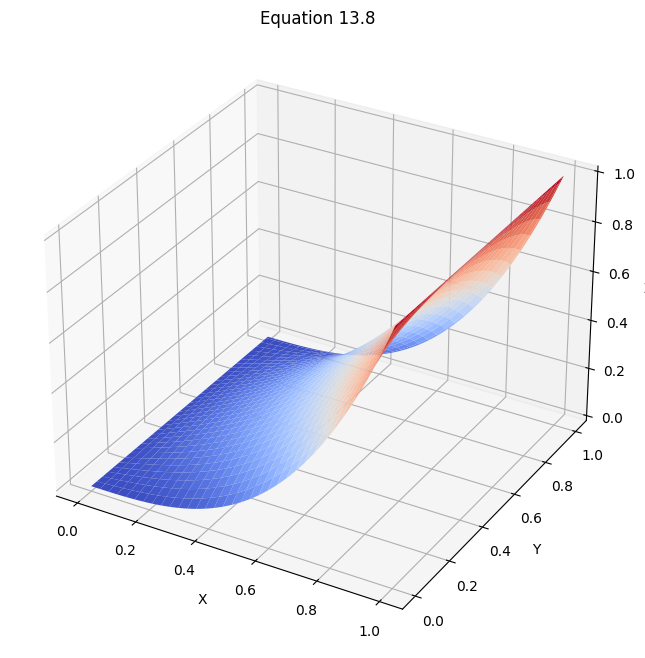

In [7]:
a, b, c, d = 0, 1, 0, 1
def f(x, y): return np.zeros_like(x)
def g(x, y): return x**3
n = 100
U = poisson_square(a, b, c, d, f, g, n)
# print(U)

x = np.linspace(a, b, n+1)
y = np.linspace(c, d, n+1)
X, Y = np.meshgrid(x, y)

# Plotting the 3D grid
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot of the 3D grid
ax.plot_surface(X, Y, U, cmap='coolwarm')

# Labels and title
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.set_title("Equation 13.8")

plt.show()

# Problem 2

Solve 

\begin{align}
	\Delta V = -\rho(x,y), &{}\quad x \in [-2,2]\times [-2,2],\\
	u(x,y) = 0, &{}\quad (x,y) \in \partial ([-2,2]\times [-2,2]).
\end{align}

for the electric potential $V.$ Use the source function defined above, such that $\rho(x,y) = \text{source}(x,y)$. Use $n=100$ subintervals for $x$ and $y$. Use the provided code to plot your solution.

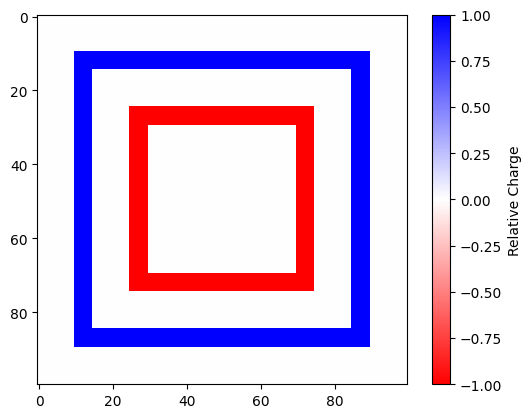

In [5]:
def source(X, Y):
    """
    Takes arbitrary arrays of coordinates X and Y and returns an array of the same shape
    representing the charge density of nested charged squares
    """
    src = np.zeros(X.shape)

    src[np.logical_or(np.logical_and(np.logical_or(abs(X - 1.5) < .1, abs(X + 1.5) < .1), abs(Y) < 1.6),
        np.logical_and(np.logical_or(abs(Y - 1.5) < .1, abs(Y + 1.5) < .1), abs(X) < 1.6))] = 1
    
    src[np.logical_or(np.logical_and(np.logical_or(abs(X - 0.9) < .1, abs(X + 0.9) < .1), abs(Y) <  1),
        np.logical_and(np.logical_or(abs(Y - 0.9) < .1, abs(Y + 0.9) < .1), abs(X) < 1))] = -1

    return src
    
# Generate a color dictionary for use with LinearSegmentedColormap
# that places red and blue at the min and max values of data
# and white when data is zero.
def genDict(data):
    zero = 1 / (1 - np.max(data) / np.min(data))
    cdict = {
        'red':   [(0, 1, 1), (zero, 1, 1), (1, 0, 0)],
        'green': [(0, 0, 0), (zero, 1, 1), (1, 0, 0)],
        'blue':  [(0, 0, 0), (zero, 1, 1), (1, 1, 1)]
    }
    return cdict

a1 = -2
b1 = 2
c1 = -2
d1 = 2
n = 100
X = np.linspace(a1, b1, n)
Y = np.linspace(c1, d1, n)
X, Y = np.meshgrid(X, Y)

plt.imshow(source(X, Y), cmap=mcolors.LinearSegmentedColormap('cmap', genDict(source(X, Y))))
plt.colorbar(label="Relative Charge")
plt.show()

/home/dbp52/.acme-venv/lib/python3.10/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:214: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',


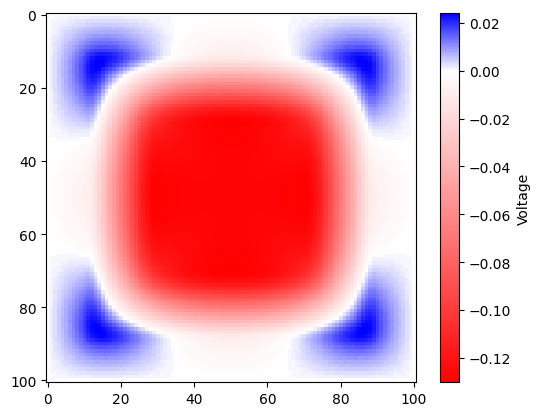

In [11]:
def f(x, y): return -source(x, y)
def g(x, y): return np.zeros_like(x)
n = 100
U = poisson_square(a1, b1, c1, d1, f, g, n)

plt.imshow(U, cmap=mcolors.LinearSegmentedColormap('coolwarm', genDict(U)))
plt.colorbar(label="Voltage")
plt.show()

# Problem 3
Using the data file dr_jarvis.jpg as the source image $v$ and mount_rushmore.jpg as the destination image $u_0$, put Dr. Jarvis' face on Mount Rushmore. Use the finite difference Laplacian operator to calculate $f$ from $v$ .

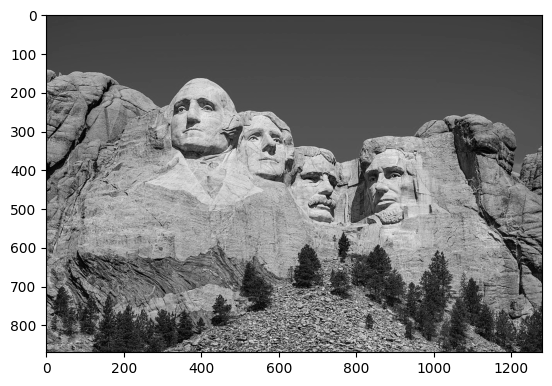

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:
source_im = np.mean(imread('dr_jarvis.jpg'), axis=2).transpose() / 255
dest_im = np.mean(imread('mount_rushmore.jpg'), axis=2).transpose() / 255

# Width of space (number of pixels) to replace in destination image
w = 130

# Position in destination image
x0 = 322
y0 = 215

# Position in source image
x0s = 60 
y0s = 84

# Show original image
plt.imshow(dest_im.transpose(), cmap='gray')
plt.show()

# Source image with a buffer of 1 pixel for the finite difference method.
# The buffer will be excluded when inserting into the Mount Rushmore image.
# The '*0.58' will make it look better when displayed.
image = source_im[x0s-1: x0s+w+1, y0s-1: y0s+w+1] * 0.58

# Calculate f(x, y)...
def f(x, y):  # TODO: What do I do here?????
    pass
    
# Calculate the solution U...
# U = poisson_square(a, b, c, d, f, g, n)    TODO: What do I do here?????    

# Paste Dr. Jarvis into the original image
new_image = dest_im.copy()
new_image[x0:x0+w, y0:y0+w] = U.reshape(w, w)

plt.imshow(new_image.transpose(), cmap='gray')
plt.show()